In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset




m_time=0
imicro=0
with Dataset('gridcell_sat_ten.nc','r') as ncFile:
    x1=ncFile.variables['x1'][:]
    x2=ncFile.variables['x2'][:]
    x3=ncFile.variables['x3'][:]
    y1=ncFile.variables['y1'][:]
    y2=ncFile.variables['y2'][:]

print(x1.std(axis=0))

[0.004881462547928095 0.00011783552326960489 0.000140866992296651
 4.451714630704373e-05 8.387665002373978e-05 0.0005601696320809424
 89667.5234375 7913.6083984375 3284.5927734375 2344.15869140625]


In [2]:
x=np.concatenate((x1[:,:6]*1e3,(x2[:,np.newaxis]-200)/90,x3[:,np.newaxis]/1e5),axis=-1)
y=np.concatenate((y1[:,:6]*1e3,y2[:,np.newaxis]),axis=-1)

In [26]:
from sklearn.model_selection import train_test_split
# import standard scaler
from sklearn.preprocessing import StandardScaler
scalerX=StandardScaler()
scalerY=StandardScaler()
x=scalerX.fit_transform(x)
y=scalerY.fit_transform(y)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

from sklearn.cluster import MiniBatchKMeans
#

#from sklearn.neighbors import KNeighborsRegressor
#knn=KNeighborsRegressor(n_neighbors=20,weights='distance')
#r=np.random.random(x_train.shape[0])
#a=np.nonzero(r<0.9)[0]
#knn.fit(x_train[a],y_train[a])
#kmeans.fit(x_train)
#from sklearn.ensemble import GradientBoostingRegressor
#gbr=GradientBoostingRegressor(n_estimators=10,learning_rate=0.1,random_state=0,loss='ls')
#gbr.fit(x_train,y_train[:,3])

In [17]:
# import kmeans
from sklearn.cluster import KMeans,MiniBatchKMeans
nclusters=500
kmeans=MiniBatchKMeans(n_clusters=nclusters,batch_size=10000)
kmeans.fit(x_train)


MiniBatchKMeans(batch_size=10000, n_clusters=500)

In [20]:

yclusterL=np.zeros((nclusters,7),float)
nm=np.zeros(nclusters,int)
for i in range(nclusters):
    a=np.nonzero(kmeans.labels_==i)[0]
    if len(a>0):
        yclusterL[i,:]=y_train[a,:].mean(axis=0)
        nm[i]=len(a)


In [21]:
print(nm.max(),nm.min(),nm.mean())

130519 0 5186.668


In [22]:
y_class=kmeans.predict(x_test)
y_pred=yclusterL[y_class,:]

In [24]:
for i in range(7):
    print(np.corrcoef(y_test[:,i],y_pred[:,i]))

[[1.         0.66367273]
 [0.66367273 1.        ]]
[[1.         0.33163223]
 [0.33163223 1.        ]]
[[1.         0.27873016]
 [0.27873016 1.        ]]
[[1.         0.27930482]
 [0.27930482 1.        ]]
[[1.         0.68953841]
 [0.68953841 1.        ]]
[[1.         0.47369214]
 [0.47369214 1.        ]]
[[1.         0.63992732]
 [0.63992732 1.        ]]


In [59]:
# define tensoflow model to predict the y from x using feedforward neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# define the model
model=Sequential()
model.add(Dense(64,input_dim=8,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(7,activation='linear'))

In [60]:
# compile the model
model.compile(loss='mse',optimizer='adam',metrics=['mse','mae'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                576       
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 7)                 455       
                                                                 
Total params: 5191 (20.28 KB)
Trainable params: 5191 (20.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [64]:
history=model.fit(x_train,y_train[:,3:4],epochs=3,batch_size=32,validation_data=(x_test,y_test[:,3:4]))

Epoch 1/3
81042/81042 [==============================] - 64s 784us/step - loss: 6.4118e-06 - mse: 6.4118e-06 - mae: 2.4935e-04 - val_loss: 2.4501e-06 - val_mse: 2.4501e-06 - val_mae: 7.1577e-04
Epoch 2/3
81042/81042 [==============================] - 62s 771us/step - loss: 3.9451e-06 - mse: 3.9451e-06 - mae: 2.2344e-04 - val_loss: 1.2324e-06 - val_mse: 1.2324e-06 - val_mae: 1.1398e-04
Epoch 3/3
81042/81042 [==============================] - 62s 760us/step - loss: 3.6082e-06 - mse: 3.6082e-06 - mae: 2.1948e-04 - val_loss: 1.6569e-06 - val_mse: 1.6569e-06 - val_mae: 1.2517e-04


In [65]:
y_pred_nn=model.predict(x_test)
#y_pred_nn=knn.predict(x_test)

34733/34733 [==============================] - 9s 264us/step


0.7964332050327055


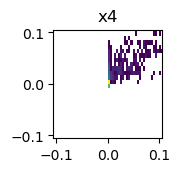

In [67]:
from matplotlib.colors import LogNorm
for i in range(3,4):
    ax=plt.subplot(3,3,i+1)
    h2=plt.hist2d(y_pred_nn[:,i-3],y_test[:,i],bins=100,norm=LogNorm())
    ax.set_aspect('equal')
    ystd=y_test[:,i].std()
    ymean=y_test[:,i].mean()
    ymin,ymax=ymean-50*ystd,ymean+50*ystd
    plt.xlim(ymin,ymax)
    plt.ylim(ymin,ymax)
    plt.title('x'+str(i+1))
    print(np.corrcoef(y_pred_nn[:,i-3],y_test[:,i])[0,1])


0.9535395490199483
0.919947639582356
0.8935728377799559
0.80326279155083
0.8812137563989517
0.8656440321533745
0.9572241634896619

In [17]:
# import PCA
from sklearn.decomposition import PCA
pca=PCA(n_components=30)
pca.fit(x_train)


[0.30879748 0.10488301 0.08973063 0.0654903  0.04840803 0.03125226
 0.02668969 0.02160023 0.0197062  0.01780255 0.01572404 0.01469852
 0.01219915 0.01145244 0.01127044 0.01084682 0.01060054 0.00971735
 0.00832586 0.00767239 0.00724144 0.00712448 0.00701564 0.00629785
 0.00597932 0.00571597 0.00564926 0.00532453 0.00525901 0.00475379]


In [18]:

print(pca.explained_variance_ratio_.cumsum())

[0.30879748 0.4136805  0.50341113 0.56890144 0.61730946 0.64856173
 0.67525142 0.69685165 0.71655786 0.73436041 0.75008445 0.76478297
 0.77698212 0.78843456 0.799705   0.81055182 0.82115236 0.83086971
 0.83919558 0.84686797 0.8541094  0.86123388 0.86824952 0.87454738
 0.8805267  0.88624267 0.89189193 0.89721646 0.90247546 0.90722925]


In [19]:
x_train_pca=pca.transform(x_train)  
x_test_pca=pca.transform(x_test)
knnpca.fit(x_train_pca,y_train)
y_pca=knnpca.predict(x_test_pca)

In [25]:
from sklearn.neighbors import NearestNeighbors
import time
t1=time.time()
r=np.random.random(x_train_pca.shape[0])
a=np.nonzero(r<0.1)
knnpca=KNeighborsRegressor(n_neighbors=30,weights='distance')
knnpca.fit(x_train_pca[a],y_train[a])
y_pca=knnpca.predict(x_test_pca)

In [27]:
import pickle
pickle.dump({"scalerX":scalerX,"pca":pca,"knnRegr":knnpca},open('knnRegr.pkl','wb'))

In [5]:
import faiss
d=x_train.shape[1]                   # make faiss available
index = faiss.IndexFlatL2(d)   # build the index
print(index.is_trained)
index.add(x_train)                  # add vectors to the index
print(index.ntotal)

True
217800


In [8]:
nneigh=50
D, I = index.search(x_test[:], nneigh) 
import pickle
pickle.dump({"x_scaled":x_train,"scalerX":scalerX,"tend":y_train},open('index.pkl','wb'))


In [ ]:
import pickle


In [9]:
print(x_test.shape)

(24200, 210)


In [48]:
print(D[0],I[0])
print(y_test.shape)

[4.4703484e-08 5.2154064e-08 5.9604645e-08 8.1956387e-08 1.1920929e-07
 1.5646219e-07 3.3527613e-07 4.2468309e-07 6.1094761e-07 8.3446503e-07
 1.3038516e-06 1.3485551e-06 1.7210841e-06 1.7657876e-06 2.0712614e-06
 2.1830201e-06 1.9540340e-03 1.9544065e-03 1.9556731e-03 1.9565597e-03] [ 89654 201369 150443 152378  78875 216187  20388   4750  30664 111017
 158650 207327 159630 153393  94073   4476 203295 166408  32439 159087]
(24200, 440)


[0.9468889715553259, 0.9423141219480339]
[-0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03
 -0.02 -0.01  0.  ]


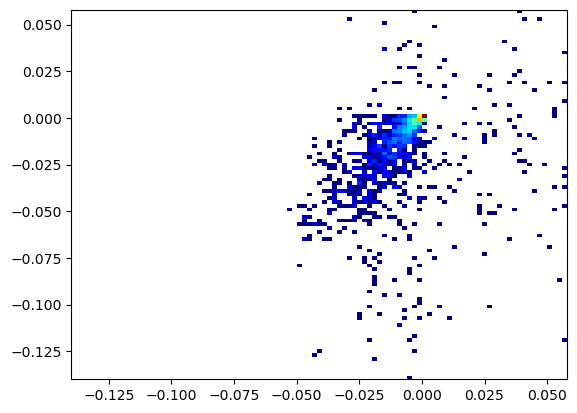

In [26]:

y_=np.mean(y_train[I],axis=1)
yL=[]
for k,i1 in enumerate(I):
    yL.append(np.dot(y_train[i1].T,np.exp(-0.125*D[k]))/np.exp(-0.125*D[k]).sum())
#print(y_.shape)
y_=y_pca
import matplotlib
plt.hist2d(y_[:,410],y_test[:,410],bins=-0.14+np.arange(0,0.20,0.002),cmap='jet',norm=matplotlib.colors.LogNorm())
print([np.corrcoef(y_[:,i],y_test[:,i])[0,1] for i in range(409,411)])
print(-0.14+np.arange(0,0.14,0.01))